# 모델 학습 및 탐지

In [4]:
import pandas as pd
import tensorflow as tf

In [5]:
print("version",tf.__version__)

version 2.1.0


### 1. 정상 데이터로만 이루어진 cic_train 데이터 셋과 정상 데이터와 공격 데이터가 섞인 cic_test 데이터 셋을 사용 

In [6]:
train=pd.read_csv('cic_train.csv')
test=pd.read_csv('cic_test.csv')

In [7]:
train_X=train.iloc[:,:-1]
train_Y=train.iloc[:,-1]
test_X=test.iloc[:,:-1]
test_Y=test.iloc[:,-1]

In [8]:
train_X.shape

(263809, 34)

In [9]:
test_Y

0         1.0
1         1.0
2         1.0
3         0.0
4         1.0
         ... 
339655    1.0
339656    0.0
339657    1.0
339658    0.0
339659    1.0
Name:  Label, Length: 339660, dtype: float64

### 2. AutoEncoder 학습

In [10]:
import sys
import numpy as np

In [11]:
#layers params#
n_inputs = train_X.shape[1]
encoding_dim=16 #인코더
coding_dim = int(encoding_dim/2) #coding units
decoding_dim = encoding_dim #디코더
n_outputs = n_inputs # reconstruction
print(n_inputs, n_outputs)

34 34


In [12]:
#train params#
learning_rate = 0.01 
l2_reg = 0.0005
learning_rate = 0.01
n_epochs = 100
batch_size = 32
n_batches = len(train_X)

In [13]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
import os
import numpy as np 
import tensorflow as tf 
from functools import partial
import tensorflow.compat.v1 as tf
# set the layers using partial
activation = tf.nn.elu
weight_initializer = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.keras.regularizers.l2(l2_reg)  # L2 규제


In [29]:

input_layer = Input(shape=(n_inputs, ))

encoder = Dense(encoding_dim, activation=tf.nn.relu, kernel_regularizer=l2_regularizer, 
                kernel_initializer=weight_initializer)(input_layer)
coding = Dense(coding_dim, activation=tf.nn.relu, kernel_regularizer=l2_regularizer, 
               kernel_initializer=weight_initializer)(encoder)
decoder = Dense(decoding_dim, activation=tf.nn.relu, kernel_regularizer=l2_regularizer,
                kernel_initializer=weight_initializer)(coding)
output_layer = Dense(n_outputs, activation=tf.nn.relu, kernel_regularizer=l2_regularizer, 
                     kernel_initializer=weight_initializer)(decoder)
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [30]:
nb_epoch =100
batch_size =32

autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                              verbose=0,
                              save_best_only=True)
history = autoencoder.fit(train_X,train_X,
                         epochs=nb_epoch,
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(test_X,test_X),
                         verbose=1,
                         callbacks=[checkpointer]
                         ).history

Train on 263809 samples, validate on 339660 samples
Epoch 1/100
263809/263809 [==============================] - 12s 45us/sample - loss: 0.0103 - accuracy: 0.8047 - val_loss: 0.0371 - val_accuracy: 0.8105
Epoch 2/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0064 - accuracy: 0.9091 - val_loss: 0.0362 - val_accuracy: 0.8146
Epoch 3/100
263809/263809 [==============================] - 12s 45us/sample - loss: 0.0063 - accuracy: 0.9075 - val_loss: 0.0351 - val_accuracy: 0.8101
Epoch 4/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0063 - accuracy: 0.9069 - val_loss: 0.0358 - val_accuracy: 0.8147
Epoch 5/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0063 - accuracy: 0.9071 - val_loss: 0.0364 - val_accuracy: 0.7781
Epoch 6/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0063 - accuracy: 0.9069 - val_loss: 0.0356 - val_accuracy: 0.8146
Epoch 7/100
263809/263809 [===

Epoch 54/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0063 - accuracy: 0.9070 - val_loss: 0.0360 - val_accuracy: 0.7781
Epoch 55/100
263809/263809 [==============================] - 11s 44us/sample - loss: 0.0063 - accuracy: 0.9068 - val_loss: 0.0363 - val_accuracy: 0.8137
Epoch 56/100
263809/263809 [==============================] - 11s 43us/sample - loss: 0.0063 - accuracy: 0.9068 - val_loss: 0.0372 - val_accuracy: 0.8140
Epoch 57/100
263809/263809 [==============================] - 11s 43us/sample - loss: 0.0063 - accuracy: 0.9071 - val_loss: 0.0357 - val_accuracy: 0.8141
Epoch 58/100
263809/263809 [==============================] - 12s 44us/sample - loss: 0.0063 - accuracy: 0.9073 - val_loss: 0.0362 - val_accuracy: 0.8062
Epoch 59/100
263809/263809 [==============================] - 11s 43us/sample - loss: 0.0063 - accuracy: 0.9070 - val_loss: 0.0367 - val_accuracy: 0.7943
Epoch 60/100
263809/263809 [==============================] - 11s 43us/sampl

#### #train 데이터의 loss는 낮은 반면, valid로 설정한 test 데이터의 loss는 높은 것을 볼 수 있다.

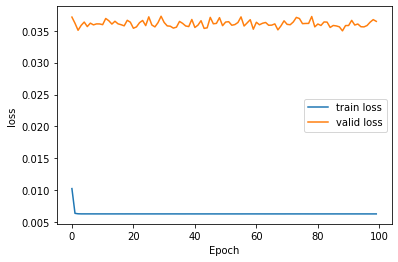

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

### 3. 탐지를 위한 임계치 설정

#### #임계치 설정을 위한 손실함수 계산

In [32]:
import numpy as np
from sklearn import metrics

predictions = autoencoder.predict(test_X)
mse = np.mean(np.power(test_X - predictions,2),axis=1)
error_df = pd.DataFrame({'reconstruction_error':mse, 'true_class':test_Y})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['true_class'], error_df['reconstruction_error'])

In [33]:
predictions

array([[0.00437295, 0.        , 0.00771112, ..., 0.        , 0.        ,
        0.        ],
       [0.86696774, 0.        , 0.06269328, ..., 0.42459953, 0.        ,
        0.41110373],
       [0.93237877, 0.        , 0.09032328, ..., 0.65985626, 0.        ,
        0.6444997 ],
       ...,
       [0.83618903, 0.        , 0.04969218, ..., 0.31390113, 0.        ,
        0.30128086],
       [0.00739825, 0.        , 0.00780884, ..., 0.        , 0.        ,
        0.        ],
       [0.00435895, 0.        , 0.00771066, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

#### #Precision과 Recall 그래프를 이용하여 두 값이 만나는 지점의 손실함수 값을 임계치로 설정

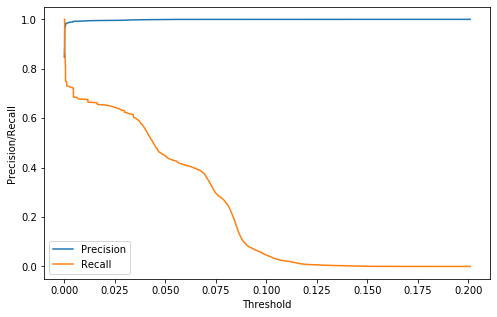

In [34]:
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [35]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.9557887042503069 , recall:  0.9557887042503069
threshold:  0.0002768409243105919


In [36]:
error_df.describe()

,reconstruction_error,true_class
count,339660.000000,339660.000000
mean,0.033768,0.741103
std,0.037486,0.438030
min,0.000040,0.000000
25%,0.000275,0.000000
50%,0.011788,1.000000
75%,0.072187,1.000000
max,0.200884,1.000000


### 4.설정된 임계치를 이용한 탐지

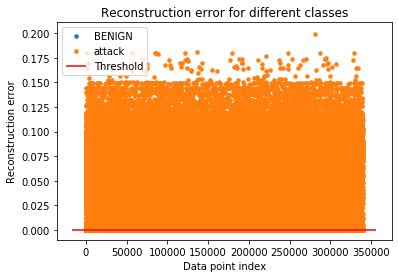

In [37]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams

#threshold = 1.338433e-06
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "attack" if name ==1 else "BENIGN")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

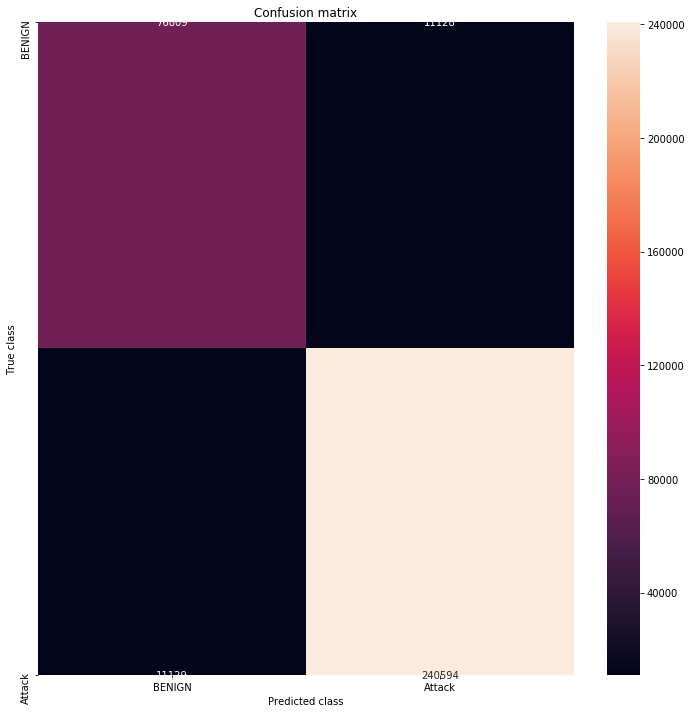

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
#threshold = 0.0001
LABELS=["BENIGN","Attack"]
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()